In [12]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats

# 1) Loading Data

In [13]:
dataPath = 'Data/2016-2019(NO2, NOX, PM2.5)'
listOfDataFrames=[]
stations=os.listdir(dataPath)
for station in stations:
    print("Processing year: "+ dataPath +" station: "+station)
    airQualityData=pd.read_csv(dataPath+'\\'+station, header=12,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
    airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
    listOfDataFrames.append(airQualityData)
airQualityData= pd.DataFrame(columns= [])
for airData in listOfDataFrames:
    airQualityData=airQualityData.append(airData)
    
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
print(airQualityData.head(5))
print(airQualityData.shape)

Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-157992-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-18644-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8779-1-6-3.csv
Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8781-1-6-1.csv
                Start              Stop   NO2   NOX   PM10  PM2_5
0 2018-01-01 00:00:00  2018-01-01 01:00  20.2  22.1  31.90   22.8
1 2018-01-01 01:00:00  2018-01-01 02:00   8.8  10.6  11.00    7.9
2 2018-01-01 02:00:00  2018-01-01 03:00   5.5   7.1   6.15    4.4
3 2018-01-01 03:00:00  2018-01-01 04:00   5.3   7.6   6.20    4.5
4 2018-01-01 04:00:00  2018-01-01 05:00   6.6   9.3   8.00    5.7
(122712, 6)


# 2) Visualizing Data

#### 1-View percentage of available data


<AxesSubplot:>

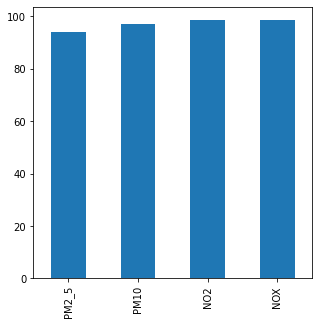

In [14]:
total = airQualityData.isnull().sum().sort_values(ascending = False)
total = total[airQualityData.isnull().sum().sort_values(ascending = False) != 0]
percent =  100 - total / len(airQualityData) * 100
percent[airQualityData.isnull().sum().sort_values(ascending = False) != 0].plot.bar(figsize = (5,5))

#### 2-Viewing subset of data

<AxesSubplot:xlabel='Start', ylabel='PM10'>

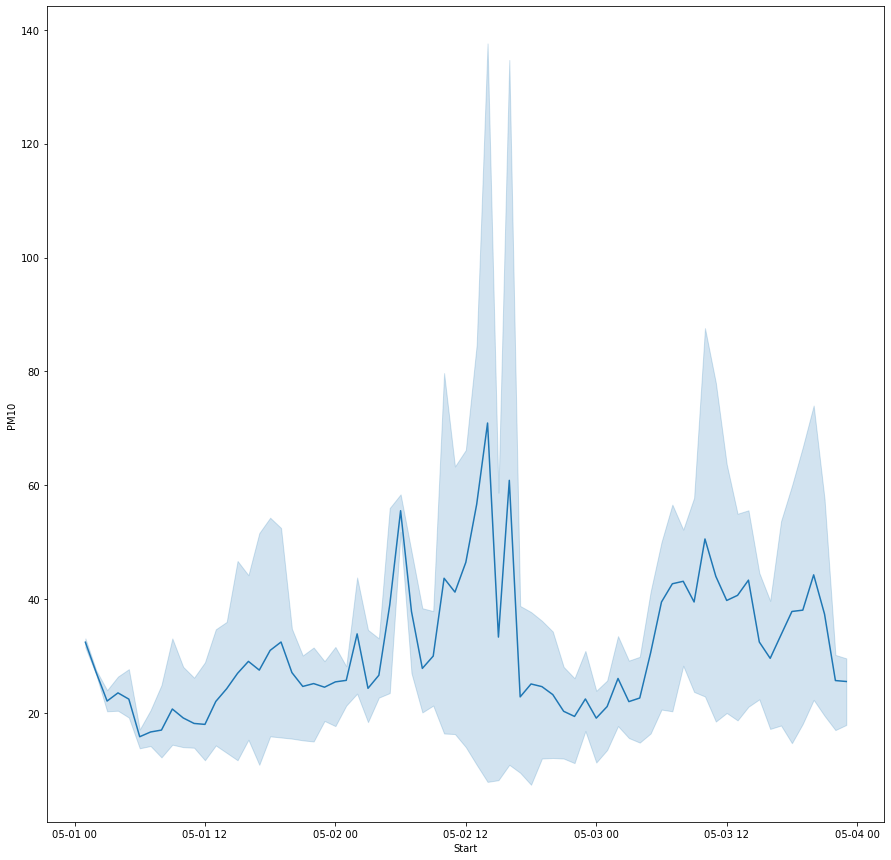

In [15]:
subsetData = airQualityData[(airQualityData['Start'] >"2016-05-01 00:00:00") & (airQualityData['Start'] < "2016-05-04 00:00:00")]
fig , ax =  plt.subplots(figsize=(15,15))
sns.lineplot(data=subsetData,x="Start",y="PM10",ax=ax)

#### 3- Histogram

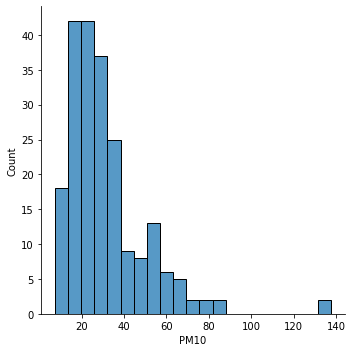

In [16]:
sns.displot(subsetData, x="PM10")

# 3) Pre-processing

In [17]:
processedAQD=airQualityData

#### 1- Replacing negative values with NaN

In [18]:
processedAQD.loc[airQualityData['PM10'] <= 0, 'PM10']=np.nan
processedAQD.loc[airQualityData['PM2_5'] <= 0, 'PM2_5']=np.nan
processedAQD.loc[airQualityData['NOX'] <= 0, 'NOX']=np.nan
processedAQD.loc[airQualityData['NO2'] <= 0, 'NO2']=np.nan

#### 2- Dropping unnecessary columns

In [19]:
processedAQD=processedAQD.drop('Stop', axis = 1)

#### 3- Removing outliers (IQR)  #Todo: check with uvais for categorical grouping -> iqr outlier removal

In [20]:
processedAQD=processedAQD.set_index('Start')
Q1 = processedAQD.quantile(0.25)
Q3=  processedAQD.quantile(0.75)
IQR= Q3-Q1
print(IQR)
processedAQD = processedAQD[~((processedAQD < (Q1 - 1.5 * IQR)) |(processedAQD > (Q3 + 1.5 * IQR))).any(axis=1)]

NO2      26.8
NOX      52.9
PM10     14.1
PM2_5     4.9
dtype: float64


#### 4- Performing Interpolation ( Imputation)

In [21]:
processedAQD = processedAQD.assign(PM10=processedAQD['PM10'].interpolate(method='time'))
processedAQD = processedAQD.assign(NO2=processedAQD['NO2'].interpolate(method='time'))
processedAQD = processedAQD.assign(NOX=processedAQD['NOX'].interpolate(method='time'))
processedAQD = processedAQD.assign(PM2_5=processedAQD['PM2_5'].interpolate(method='time'))

# 4) Feature selection

In [22]:
processedAQD=processedAQD.reset_index()

#### 1) Correlation

<AxesSubplot:title={'center':'Before Processing'}>

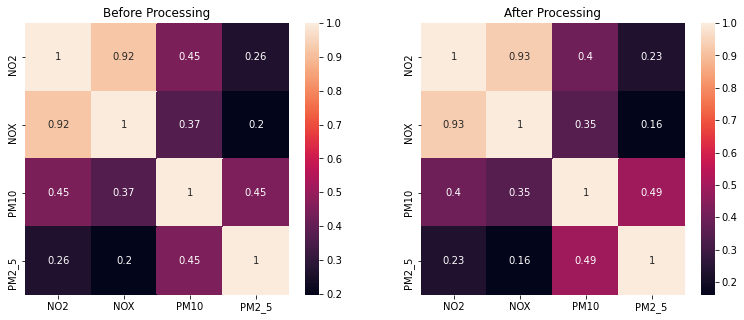

In [23]:
fig , ax =plt.subplots(1,2,figsize=(13,5))
ax[0].set_title("Before Processing")
ax[1].set_title("After Processing")
sns.heatmap(processedAQD.corr(), annot=True,ax= ax[1])
sns.heatmap(airQualityData[['NO2','NOX','PM10','PM2_5']].corr(), annot=True,ax= ax[0])

# PLAYGROUND

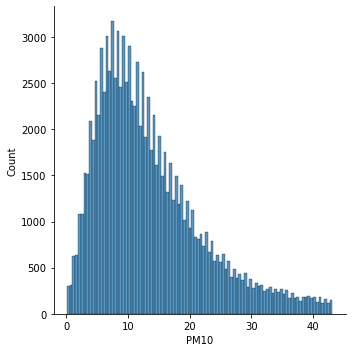

In [25]:
sns.displot(processedAQD, x="PM10")

In [37]:
processedAQD['PM10'].skew()

1.1009973617141455

In [43]:
sqr_dist=airQualityData
sqr_dist=sqr_dist.drop()
sqr_dist=sqr_dist.set_index('Start')
sqr_dist=sqr_dist**(.5)

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'float'

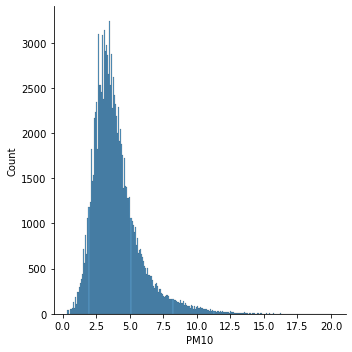

In [39]:
sns.displot(sqr_dist)

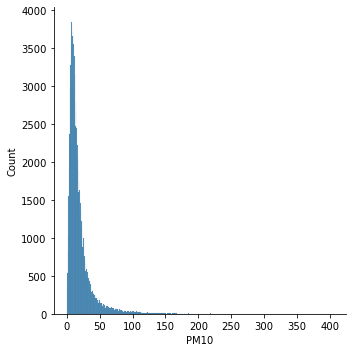

In [40]:
sns.displot(airQualityData['PM10'])